CPS without noise reduction


===== Processing: HL2_20250415_153040.wav =====
Audio File: HL2_20250415_153040.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 19.93
Maximum CPS: 42.00
Minimum CPS: 2.20
Frames with CPS >= 5: 258
Frames with CPS >= 10: 215


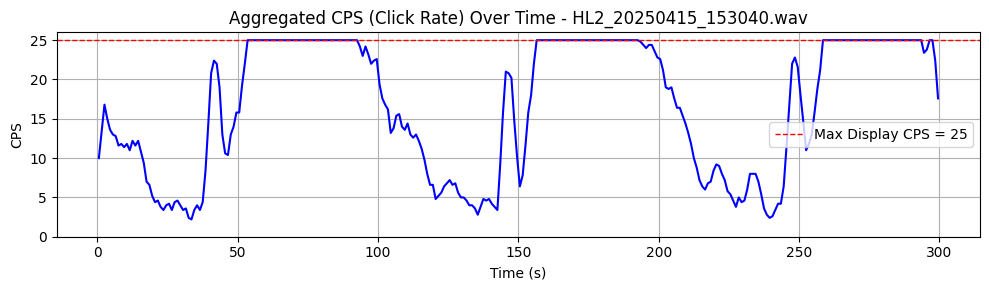


===== Processing: HL2_20250415_154400.wav =====
Audio File: HL2_20250415_154400.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 19.99
Maximum CPS: 41.20
Minimum CPS: 4.60
Frames with CPS >= 5: 299
Frames with CPS >= 10: 225


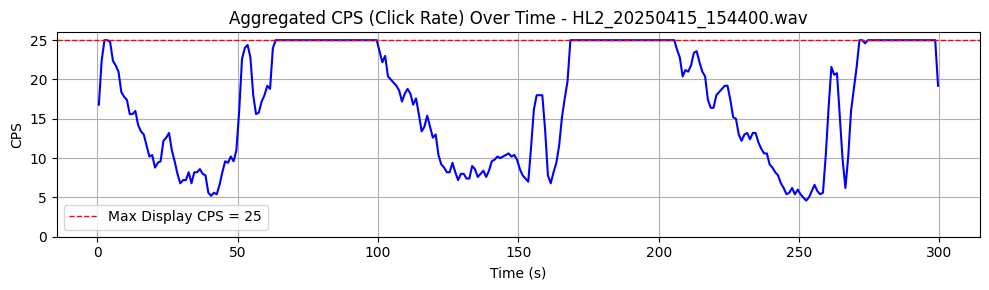


===== Processing: HL2_20250415_155713.wav =====
Audio File: HL2_20250415_155713.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 11.03
Maximum CPS: 36.60
Minimum CPS: 1.20
Frames with CPS >= 5: 183
Frames with CPS >= 10: 133


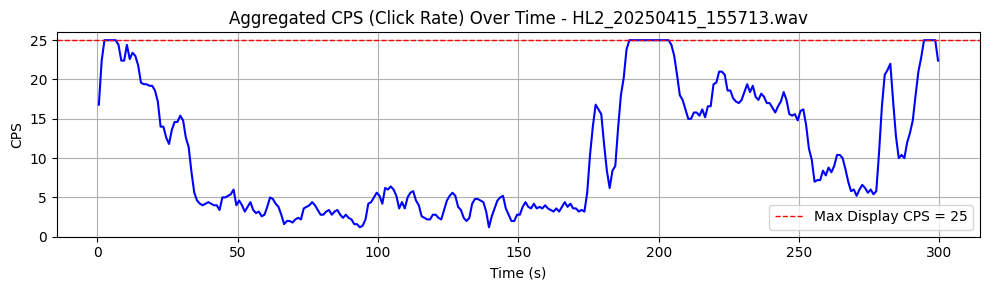


===== Processing: HL2_20250415_161033.wav =====
Audio File: HL2_20250415_161033.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 15.62
Maximum CPS: 35.40
Minimum CPS: 1.80
Frames with CPS >= 5: 254
Frames with CPS >= 10: 195


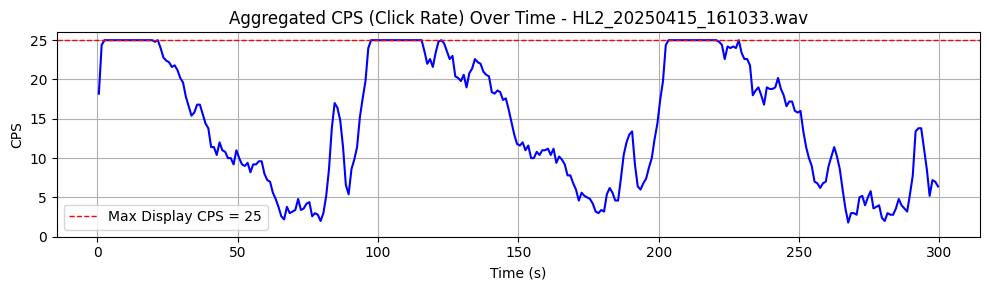


===== Processing: HL2_20250415_162352.wav =====
Audio File: HL2_20250415_162352.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 17.44
Maximum CPS: 39.20
Minimum CPS: 1.00
Frames with CPS >= 5: 239
Frames with CPS >= 10: 189


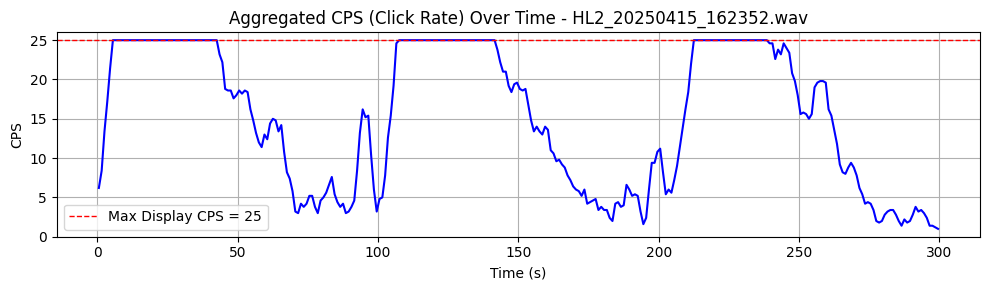


===== Processing: HL2_20250415_163711.wav =====
Audio File: HL2_20250415_163711.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 17.67
Maximum CPS: 43.00
Minimum CPS: 0.40
Frames with CPS >= 5: 246
Frames with CPS >= 10: 184


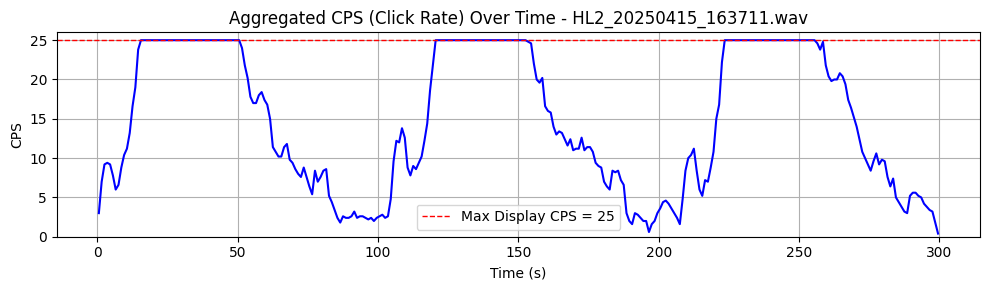


===== Processing: HL2_20250415_165031.wav =====
Audio File: HL2_20250415_165031.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 19.02
Maximum CPS: 47.40
Minimum CPS: 0.80
Frames with CPS >= 5: 233
Frames with CPS >= 10: 191


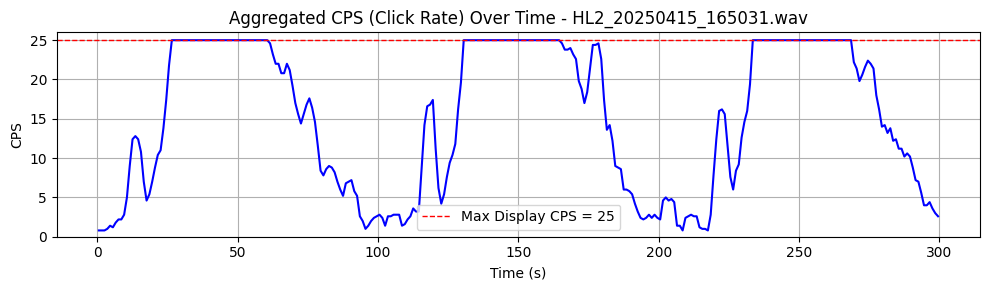


===== Processing: HL2_20250415_170348.wav =====
Audio File: HL2_20250415_170348.wav
Duration: 300.00 seconds
Sampling Rate: 44100 Hz

CPS Statistics:
Average CPS: 19.67
Maximum CPS: 49.60
Minimum CPS: 1.20
Frames with CPS >= 5: 241
Frames with CPS >= 10: 189


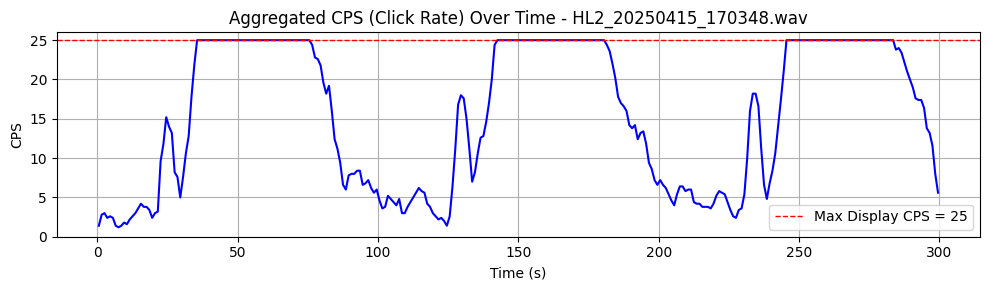

In [13]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, sosfiltfilt
import os

# Configuration Parameters
SAMPLE_RATE = 44100
PEAK_HEIGHT = 0.01  # Minimum amplitude for a shrimp click
PEAK_DISTANCE = int(SAMPLE_RATE / 100)  # ~10ms at 44100 Hz
MAX_CPS_DISPLAY = 25

# Step 1: Load the audio file
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    return audio, sr

# Step 2: Apply a bandpass filter (2000–6000 Hz)
def bandpass_filter(audio, sr, lowcut=2000, highcut=6000):
    sos = butter(10, [lowcut, highcut], btype='band', fs=sr, output='sos')
    filtered_audio = sosfiltfilt(sos, audio)
    return filtered_audio

# Step 3: Detect clicks and calculate CPS in each frame
def calculate_cps(audio, sr, frame_duration=1.0, threshold_energy=PEAK_HEIGHT, min_distance=PEAK_DISTANCE):
    # Number of samples per frame
    frame_samples = int(frame_duration * sr)
    hop_samples = frame_samples  # Non-overlapping frames
    num_frames = len(audio) // hop_samples
    
    # Initialize arrays
    cps = []
    frame_times = []
    
    # Process each frame
    for i in range(num_frames):
        start = i * hop_samples
        end = start + frame_samples
        frame = audio[start:end]
        
        # Detect peaks in the frame
        peaks, _ = find_peaks(np.abs(frame), height=threshold_energy, distance=min_distance)
        
        # Calculate CPS for this frame
        clicks_in_frame = len(peaks)
        cps_value = clicks_in_frame / frame_duration
        cps.append(cps_value)
        
        # Time at the center of the frame
        frame_times.append((start + end) / (2 * sr))
    
    # Smooth the CPS values to reduce noise
    cps = np.array(cps)
    window_size = 5
    cps = np.convolve(cps, np.ones(window_size)/window_size, mode='same')
    
    return cps, np.array(frame_times)

# Step 4: Plot the CPS over time
def plot_aggregated_cps(time_axis, cps_values, audio_duration, max_cps=MAX_CPS_DISPLAY, file_title="Audio File"):
    # Truncate any values above max_cps
    cps_truncated = np.clip(cps_values, 0, max_cps)
    
    # Create the plot
    plt.figure(figsize=(10, 3))
    plt.plot(time_axis, cps_truncated, linestyle='-', color='blue')
    plt.axhline(max_cps, color='red', linestyle='--', linewidth=1, label=f"Max Display CPS = {max_cps}")
    
    plt.title(f"Aggregated CPS (Click Rate) Over Time - {file_title}")
    plt.xlabel("Time (s)")
    plt.ylabel("CPS")
    plt.ylim(0, max_cps + 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function
def analyze_cps(file_path):
    # Load audio
    audio, sr = load_audio(file_path)
    audio_duration = len(audio) / sr
    file_title = os.path.basename(file_path)  # Get the file name (without path)
    
    # Print processing header
    print(f"\n===== Processing: {file_title} =====")
    print(f"Audio File: {file_title}")
    print(f"Duration: {audio_duration:.2f} seconds")
    print(f"Sampling Rate: {sr} Hz")
    
    # Apply bandpass filter (2000–6000 Hz)
    filtered_audio = bandpass_filter(audio, sr, lowcut=2000, highcut=6000)
    
    # Calculate CPS
    cps, frame_times = calculate_cps(filtered_audio, sr, frame_duration=1.0)

    # Print CPS Statistics
    print("\nCPS Statistics:")
    print(f"Average CPS: {np.mean(cps):.2f}")
    print(f"Maximum CPS: {np.max(cps):.2f}")
    print(f"Minimum CPS: {np.min(cps):.2f}")
    print(f"Frames with CPS >= 5: {np.sum(cps >= 5)}")
    print(f"Frames with CPS >= 10: {np.sum(cps >= 10)}")
    
    # Plot CPS
    plot_aggregated_cps(frame_times, cps, audio_duration, file_title=file_title)

# Process all .wav files in the current directory
def analyze_folder(folder_path):
    # List all .wav files in the folder
    wav_files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
    
    # Analyze each file
    for wav_file in wav_files:
        file_path = os.path.join(folder_path, wav_file)
        try:
            analyze_cps(file_path)
        except FileNotFoundError:
            print(f"Error: The file {file_path} was not found. Please provide a valid audio file path.")

# Example usage
if __name__ == "__main__":
    folder_path = "."  # Current directory
    analyze_folder(folder_path)
